<div>
    <img src="https://storage.googleapis.com/kaggle-datasets-images/30292/38613/ab6171de10588e40148aed91ff39e2e9/dataset-cover.jpg" />
</div>

In [ ]:
import math
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.neural_network import MLPRegressor
from mxnet import autograd, gluon, np, npx
from mxnet import init
from mxnet.gluon import nn
import mxnet as mx

!pip install -qq d2l==0.16.3
from d2l import mxnet as d2l

from IPython.display import clear_output

npx.set_np()

<h1 id="dataset" style="color:#d48100; background:#dadde4; border:0.5px dotted #9bbc5c;"> 
    <center>Dataset
        <a class="anchor-link" href="#dataset" target="_self">¶</a>
    </center>
</h1>

## Load Data

In [ ]:
path = '../input/avocado-prices/avocado.csv'
df = pd.read_csv(path)

df.set_index('Date', inplace=True)
df.sort_values(by='Date', inplace=True)

df.head()

## Features Engineering

In [ ]:
average_prices = np.array(df['AveragePrice'].values)

X = np.arange(len(average_prices)).astype(np.float32)
y = average_prices.astype(np.float32)

y /= y.max()

In [ ]:
plt.figure(figsize=(11,8))
plt.plot(X[:50], y[:50], 'b-')

## Split Training/Testing

In [ ]:
n_train = 50
n_test = 50

x_train = X[:n_train]

# Training outputs
y_train = y[:n_train]

# Testing examples
x_test = np.arange(0, 50, 1)
y_truth = y[x_test]

<h1 id="goal" style="color:#d48100; background:#dadde4; border:0.5px dotted #9bbc5c;"> 
    <center>Goal
        <a class="anchor-link" href="#goal" target="_self">¶</a>
    </center>
</h1>

In [ ]:
def plot_kernel_reg(y_hat):
    d2l.plot(x_test, [y_truth, y_hat], 'x', 'y', legend=['Truth', 'Pred'],
             xlim=[0, 50], ylim=[0, 1], figsize=(8,8))
    d2l.plt.plot(x_train, y_train, 'o', alpha=0.5);

Goal of the notebook is to use nonparametric Nadaraya-Watson Kernel Regression in order to predict the prices of the avocados.

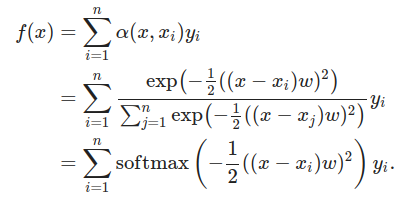

## Model

In [ ]:
class NWKernelRegression(nn.Block):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = self.params.get('w', shape=(1,))

    def forward(self, queries, keys, values):
        # Shape of the output `queries` and `attention_weights`:
        # (no. of queries, no. of key-value pairs)
        queries = queries.repeat(keys.shape[1]).reshape((-1, keys.shape[1]))
        self.attention_weights = npx.softmax(
            -((queries - keys) * self.w.data())**2 / 2)
        # Shape of `values`: (no. of queries, no. of key-value pairs)
        return npx.batch_dot(np.expand_dims(self.attention_weights, 1),
                             np.expand_dims(values, -1)).reshape(-1)

## Intial Prediction

In [ ]:
net = NWKernelRegression()
net.initialize(init=init.Normal(sigma=0.5), force_reinit=True)

keys = np.tile(x_train, (n_test, 1))
values = np.tile(y_train, (n_test, 1))
y_hat = net(x_test, keys, values)
plot_kernel_reg(y_hat)

<h1 id="train" style="color:#d48100; background:#dadde4; border:0.5px dotted #9bbc5c;"> 
    <center>Training
        <a class="anchor-link" href="#train" target="_self">¶</a>
    </center>
</h1>

## Creation of the tiles

In [ ]:
n_train = len(x_train)

keys = np.tile(x_train, (n_test, 1))
values = np.tile(y_train, (n_test, 1))

## Training

In [ ]:
loss = gluon.loss.L2Loss()
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.5})

In [ ]:
losses = []
for epoch in range(30):
    with autograd.record():
        l = loss(net(x_train, keys, values), y_train)
    l.backward()
    losses.append(l.sum())
    trainer.step(1)
    clear_output(wait=True)
    print(f'epoch {epoch + 1}, loss {float(l.sum()):.6f}')

<h1 id="analysis" style="color:#d48100; background:#dadde4; border:0.5px dotted #9bbc5c;"> 
    <center>Analysis
        <a class="anchor-link" href="#analysis" target="_self">¶</a>
    </center>
</h1>

## Loss

In [ ]:
_ = plt.figure(figsize=(8,8))
_ = plt.title("Train Losses")
_ = plt.plot(losses)
plt.show()

## Predictions

In [ ]:
keys = np.tile(x_train, (n_test, 1))
values = np.tile(y_train, (n_test, 1))
y_hat = net(x_test, keys, values)
plot_kernel_reg(y_hat)